In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm
from utils import logger, rule_base_predict, to_yolo

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains
from selenium.webdriver.common.keys import Keys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba

START_TS = datetime.now()

2021-05-21 11:53:24,557 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-21 11:53:24,557 -INFO - common:common.py:549 - Module utils.common is loaded...
2021-05-21 11:53:24,562 -INFO - dataset_builder:dataset_builder.py:244 - dataset package is loaded...
2021-05-21 11:53:25,227 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

## Parameters

2021-05-21 11:53:25,278 -INFO - dataset_builder:dataset_builder.py:121 - Dataset name: ozon
2021-05-21 11:53:25,279 -INFO - dataset_builder:dataset_builder.py:130 - Create directories to save the dataset
2021-05-21 11:53:25,281 -INFO - dataset_builder:dataset_builder.py:165 - Creating driver
2021-05-21 11:53:26,431 -INFO - dataset_builder:dataset_builder.py:173 - Chrome web driver is created
2021-05-21 11:53:26,546 -INFO - <ipython-input-4-10d69dc0fb1f>:<ipython-input-4-10d69dc0fb1f>:11 - getting url: https://www.ozon.ru/category/smartfony-15502/?from_global=true&rsdiagonalstr=1.000%3B10.000&text=%D1%81%D0%BC%D0%B0%D1%80%D1%82%D1%84%D0%BE%D0%BD%D1%8B
2021-05-21 11:53:30,876 -INFO - dataset_builder:dataset_builder.py:176 - save scrinshot: dataset/images/ozon.png
2021-05-21 11:53:32,183 -INFO - dataset_builder:dataset_builder.py:220 - Collect features using JS script
2021-05-21 11:53:36,041 -INFO - dataset_builder:dataset_builder.py:228 - Save html to dataset/html/ozon.html
2021-05-21 11

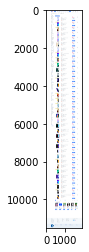

In [4]:
SITE_URL = 'https://www.ozon.ru/category/smartfony-15502/?from_global=true&rsdiagonalstr=1.000%3B10.000&text=%D1%81%D0%BC%D0%B0%D1%80%D1%82%D1%84%D0%BE%D0%BD%D1%8B'
DATASET_NAME = 'ozon'
class JDIDatasetBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        driver.set_window_size(width=1920, height=11500)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        #maximize_window(driver=driver, extend_pix=0)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))



In [5]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')

In [6]:
controls_df = rule_base_predict(df)
controls_df

2021-05-21 11:53:38,020 -INFO - common:common.py:463 - Num radio buttons found: 4
2021-05-21 11:53:38,024 -INFO - common:common.py:467 - Num checkboxes found: 103
2021-05-21 11:53:38,030 -INFO - common:common.py:473 - Num comboboxes/dropdowns found: 1
2021-05-21 11:53:38,036 -INFO - common:common.py:479 - Num textfields found: 1
2021-05-21 11:53:38,042 -INFO - common:common.py:484 - Num texfields for numbers found: 1
2021-05-21 11:53:38,047 -INFO - common:common.py:489 - Num ranges found: 10
2021-05-21 11:53:38,052 -INFO - common:common.py:494 - Num ordinary text inputs found: 10
2021-05-21 11:53:38,054 -INFO - common:common.py:497 - Num buttons found: 132
2021-05-21 11:53:38,059 -INFO - common:common.py:501 - Num links found: 296


element_id      x       y  width  height  label
505  5916853271872121901802724977  248.5   451.5    0.0     0.0      7
511  8027212763872121902333192566  248.5   479.0    0.0     0.0      7
519  6337719380872121901049818447  248.5   506.5    0.0     0.0      7
525  1771883945872121908714626040  248.5   532.5    0.0     0.0      7
534  9945896596872121909284473911  401.5   574.0   13.0    13.0      5
..                            ...    ...     ...    ...     ...    ...
766  2477761299872121901684553077  243.5  2019.0  190.0    24.0     14
784  7368412563872121903105943965  243.5  2151.0  190.0    24.0     14
785  8746088951872121901443144923  243.5  2151.0  190.0    24.0     14
875  7167630550872121903633034210  243.5  2763.0  190.0    24.0     14
876  7313819310872121900671977955  243.5  2763.0  190.0    24.0     14

[558 rows x 6 columns]

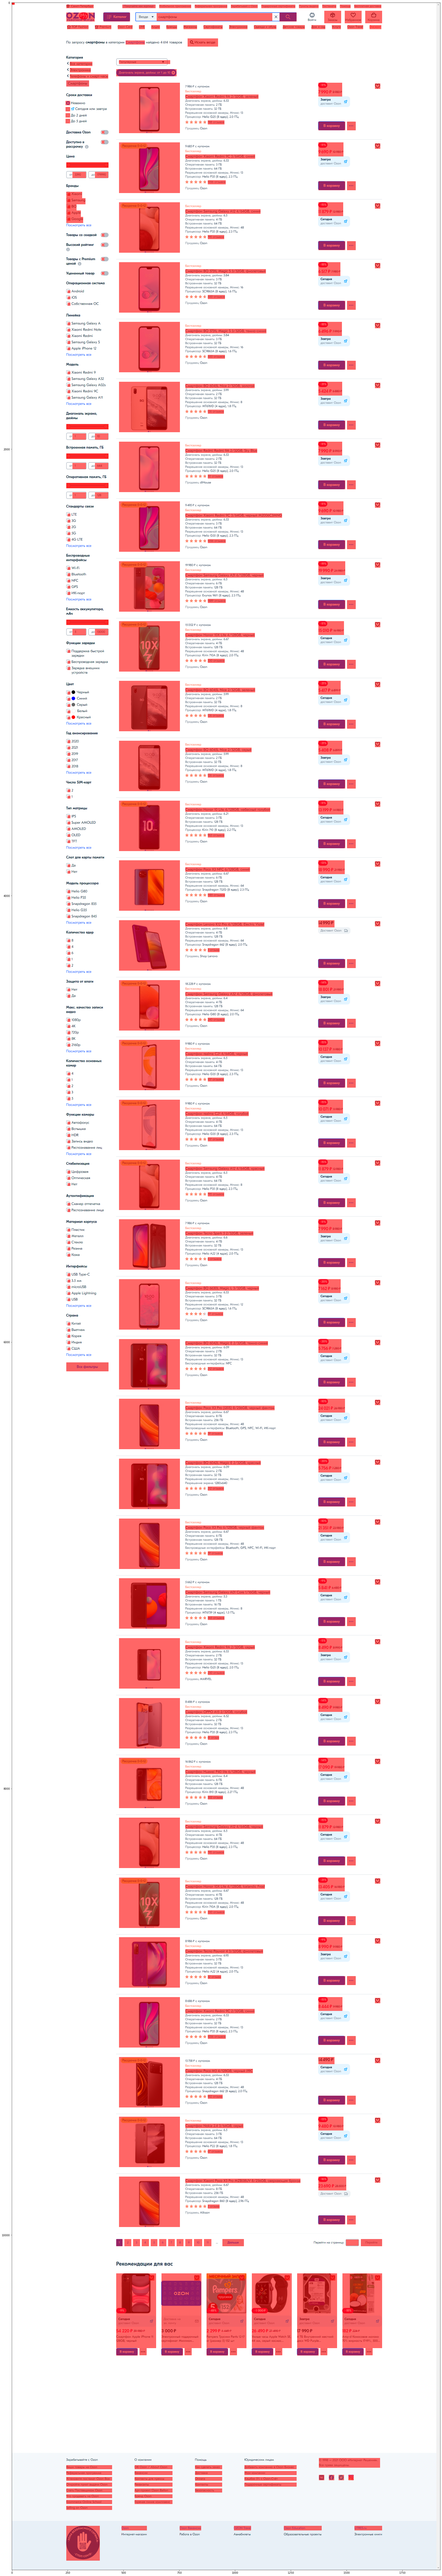

In [7]:
plt.figure(figsize=(30,200))
img = plt.imread(f'dataset/images/{DATASET_NAME}.png')
plt.imshow(img)
axes = plt.gca()

COLUMNS = ['element_id', 'x', 'y', 'width', 'height']

def display_controls(df: pd.DataFrame, axes=axes, color='red'):
    for r in df.iterrows():
        idx, ( uuid, x, y, w, h) = r

        if w == 0:
            w += 20 
            x -= 8
        if h == 0:
            h += 20 
            y -= 12

        patch = patches.Rectangle((x,y), w, h, linewidth=2, alpha = .6, facecolor = color)
        axes.add_patch(patch)
        # print(idx, x, y, w, h)
    
display_controls(controls_df[COLUMNS])


In [8]:
img.shape

(11500, 1920, 4)

In [9]:
    
display(to_yolo(**{'label': 5, 'x': 0, 'y': 0, 'w': 0, 'h': 0, 'img_width': img.shape[1], 'img_height': img.shape[0]}))
display(to_yolo(**{'label': 5, 'x': 100, 'y': 100, 'w': 0, 'h': 0, 'img_width': img.shape[1], 'img_height': img.shape[0]}))


[5, 0, 0, 0, 0]

[5, 0.054167, 0.008696, 0.010417, 0.001739]

In [10]:
controls_df['yolo'] = controls_df.apply(
    lambda r: to_yolo(label=r['label'],  
                      x=r['x'], 
                      y=r['y'], 
                      w=r['width'], 
                      h=r['height'], 
                      img_width=img.shape[1], 
                      img_height=img.shape[0]), 
    axis=1
)

In [11]:
controls_df

element_id      x       y  width  height  label  \
505  5916853271872121901802724977  248.5   451.5    0.0     0.0      7   
511  8027212763872121902333192566  248.5   479.0    0.0     0.0      7   
519  6337719380872121901049818447  248.5   506.5    0.0     0.0      7   
525  1771883945872121908714626040  248.5   532.5    0.0     0.0      7   
534  9945896596872121909284473911  401.5   574.0   13.0    13.0      5   
..                            ...    ...     ...    ...     ...    ...   
766  2477761299872121901684553077  243.5  2019.0  190.0    24.0     14   
784  7368412563872121903105943965  243.5  2151.0  190.0    24.0     14   
785  8746088951872121901443144923  243.5  2151.0  190.0    24.0     14   
875  7167630550872121903633034210  243.5  2763.0  190.0    24.0     14   
876  7313819310872121900671977955  243.5  2763.0  190.0    24.0     14   

                                             yolo  
505    [7, 0.13151, 0.039261, 0.010417, 0.001739]  
511    [7, 0.13151, 0.041652, 0.010417, 0.001739]  
519    [7, 0.13151, 0.044043, 0.010417, 0.001739]  
525    [7, 0.13151, 0.046304, 0.010417, 0.001739]  
534      [5, 0.2125, 0.050478, 0.006771, 0.00113]  
..                                            ...  
766  [14, 0.176302, 0.176609, 0.098958, 0.002087]  
784  [14, 0.176302, 0.188087, 0.098958, 0.002087]  
785  [14, 0.176302, 0.188087, 0.098958, 0.002087]  
875  [14, 0.176302, 0.241304, 0.098958, 0.002087]  
876  [14, 0.176302, 0.241304, 0.098958, 0.002087]  

[558 rows x 7 columns]

In [12]:
labeled_df = pd.DataFrame(controls_df.yolo.values.tolist(), columns=['label', 'x', 'y', 'width', 'height'])
display(labeled_df)
labeled_df.to_csv(f'dataset/annotations/{DATASET_NAME}.txt', header=False, sep=' ', index=False)

label         x         y     width    height
0        7  0.131510  0.039261  0.010417  0.001739
1        7  0.131510  0.041652  0.010417  0.001739
2        7  0.131510  0.044043  0.010417  0.001739
3        7  0.131510  0.046304  0.010417  0.001739
4        5  0.212500  0.050478  0.006771  0.001130
..     ...       ...       ...       ...       ...
553     14  0.176302  0.176609  0.098958  0.002087
554     14  0.176302  0.188087  0.098958  0.002087
555     14  0.176302  0.188087  0.098958  0.002087
556     14  0.176302  0.241304  0.098958  0.002087
557     14  0.176302  0.241304  0.098958  0.002087

[558 rows x 5 columns]